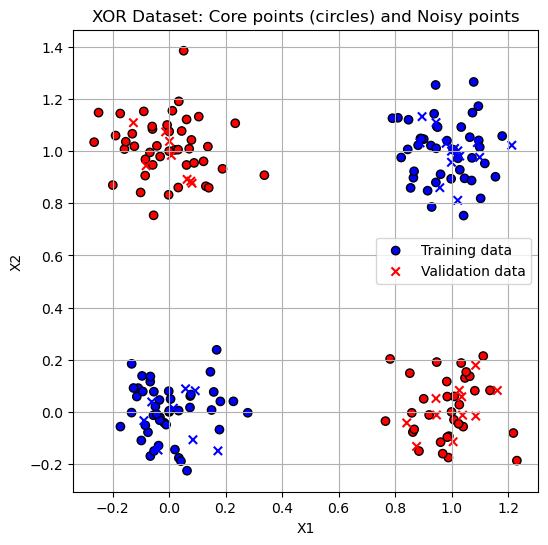

In [43]:
#Problem 2 Part A: Create XOR Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# XOR core points and labels
core_points = np.array([[0,0],[0,1],[1,0],[1,1]])
core_labels = np.array([0,1,1,0])  # XOR output

# Generate 200 noisy samples around core points
num_noisy_samples = 200
noise_sigma = 0.1  # can vary between 0.05 to 0.15

np.random.seed(42)  # for reproducibility

noisy_points = []
noisy_labels = []

for _ in range(num_noisy_samples):
    # Pick a random corner
    idx = np.random.choice(4)
    base_point = core_points[idx]
    label = core_labels[idx]
    # Add Gaussian noise
    noise = np.random.normal(0, noise_sigma, 2)
    noisy_sample = base_point + noise
    noisy_points.append(noisy_sample)
    noisy_labels.append(label)

# Combine core and noisy points
X = np.vstack((core_points, np.array(noisy_points)))
y = np.hstack((core_labels, np.array(noisy_labels)))

# Train-validation split (stratified)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Plot dataset
plt.figure(figsize=(6,6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='bwr', edgecolors='k', label='Training data')
plt.scatter(X_valid[:,0], X_valid[:,1], c=y_valid, cmap='bwr', marker='x', label='Validation data')
plt.title('XOR Dataset: Core points (circles) and Noisy points')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
#: Define MLP Model for XOR (Binary output with sigmoid)
import torch
import torch.nn as nn

class XORNet(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=4, activation='Tanh'):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Single logit output
        activations = {
            'ReLU': nn.ReLU(),
            'Tanh': nn.Tanh(),
        }
        self.activation = activations.get(activation, nn.Tanh())
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


In [45]:
#Step 2: Prepare the XOR data from Part A (as PyTorch tensors and DataLoaders)
import torch.utils.data as data

# Assume X_train, y_train, X_valid, y_valid are numpy arrays from Part A
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float().unsqueeze(1)  # shape (N,1)
X_valid_t = torch.from_numpy(X_valid).float()
y_valid_t = torch.from_numpy(y_valid).float().unsqueeze(1)

batch_size = 16
train_dataset = data.TensorDataset(X_train_t, y_train_t)
valid_dataset = data.TensorDataset(X_valid_t, y_valid_t)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = data.DataLoader(valid_dataset, batch_size=batch_size)


In [47]:
#Step 3: Define Training Loop

def train_model_with_tracking(model, train_loader, valid_loader, lr=0.001, epochs=200, optimizer_name='Adam'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.BCELoss()
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError("Unsupported optimizer")

    train_accuracies, train_losses = [], []
    valid_accuracies, valid_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * y_batch.size(0)
            predicted = (preds >= 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        running_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for x_val, y_val in valid_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_preds = model(x_val)
                loss = criterion(val_preds, y_val)
                running_loss += loss.item() * y_val.size(0)
                predicted = (val_preds >= 0.5).float()
                correct += (predicted == y_val).sum().item()
                total += y_val.size(0)
        valid_loss = running_loss / total
        valid_acc = correct / total
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}: Train Acc: {train_acc:.3f}, Val Acc: {valid_acc:.3f}, "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}")

    # Final report
    print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
    print(f"Final Validation Accuracy: {valid_accuracies[-1]:.4f}")
    return train_accuracies, valid_accuracies, train_losses, valid_losses



In [31]:
model = XORNet(hidden_dim=4, activation='Tanh')
train_acc, val_acc, train_loss, val_loss = train_model_with_tracking(model, train_loader, valid_loader, lr=0.001, epochs=200, optimizer_name='Adam')



Epoch 1: Train Acc: 0.534, Val Acc: 0.537, Train Loss: 0.6856, Val Loss: 0.7027
Epoch 10: Train Acc: 0.540, Val Acc: 0.537, Train Loss: 0.6810, Val Loss: 0.6996
Epoch 20: Train Acc: 0.644, Val Acc: 0.585, Train Loss: 0.6764, Val Loss: 0.6960
Epoch 30: Train Acc: 0.699, Val Acc: 0.659, Train Loss: 0.6717, Val Loss: 0.6921
Epoch 40: Train Acc: 0.748, Val Acc: 0.659, Train Loss: 0.6662, Val Loss: 0.6868
Epoch 50: Train Acc: 0.767, Val Acc: 0.683, Train Loss: 0.6596, Val Loss: 0.6812
Epoch 60: Train Acc: 0.785, Val Acc: 0.732, Train Loss: 0.6518, Val Loss: 0.6747
Epoch 70: Train Acc: 0.798, Val Acc: 0.732, Train Loss: 0.6428, Val Loss: 0.6660
Epoch 80: Train Acc: 0.779, Val Acc: 0.732, Train Loss: 0.6324, Val Loss: 0.6571
Epoch 90: Train Acc: 0.798, Val Acc: 0.732, Train Loss: 0.6202, Val Loss: 0.6454
Epoch 100: Train Acc: 0.798, Val Acc: 0.732, Train Loss: 0.6065, Val Loss: 0.6316
Epoch 110: Train Acc: 0.798, Val Acc: 0.732, Train Loss: 0.5909, Val Loss: 0.6157
Epoch 120: Train Acc: 0.798

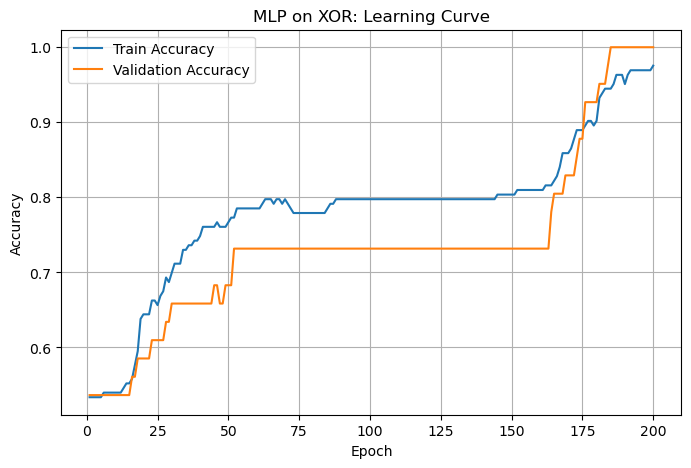

In [33]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc)+1)
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MLP on XOR: Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


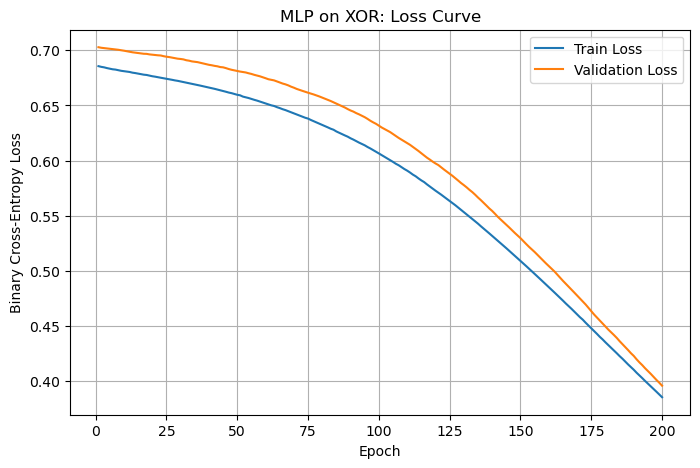

In [35]:
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('MLP on XOR: Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


Why is XOR not linearly separable?

XOR outputs 1 when exactly one input is 1. If you plot the points the two '1" outputs sit diagonally across from each other with the 0" outputs in between. You cant draw a single straight line to separate them—no matter how you try some points end up on the wrong side. Thats why XOR is the classic example of a problem that needs something more than a simple linear classifier.


How does a hidden layer with nonlinearity help solve XOR?

A hidden layer with nonlinear activations (like Tanh or ReLU) warps and stretches the input space. It basically transforms the problem into a new space where you can draw a line to separate the classes. The network learns to twist things around so XOR becomes solvable—something a purely linear model just cant do.


Compare tanh vs. ReLU for this task (convergence, boundary, stability).

Tanh squashes outputs between - 1 and 1  giving smooth balanced gradients that can make training more stable for XOR. ReLU just cuts off negative values and passes positive ones through, which can make learning faster but sometimes creates dead neurons. For XOR Tanh usually gives a smoother boundary but ReLU works fine too and is simpler to compute.


What changes for model capacity/fit as H goes from 1 to 8?

With H= 1 (just one hidden neuron), the model doesn't have enough power to capture XORs twisty pattern— it fails. Bump H up to 4 or 8 and now the model has enough capacity to learn the nonlinear boundary and nail XOR perfectly. More hidden units =more expressive power= better fit.


How does increasing input noise affect boundary/generalization?

More noise makes the data messier — points blur together and classes overlap. The model might draw jagged boundaries trying to fit every noisy point (overfitting) or learn boundaries that are too smooth and miss the real pattern. A good model finds a balance learning boundaries that work on clean data and dont freak out when things get noisy.

